## Machine Learning

Programming tradisional memerintahkan mesin untuk melakukan suatu hal secara eksplisit. 

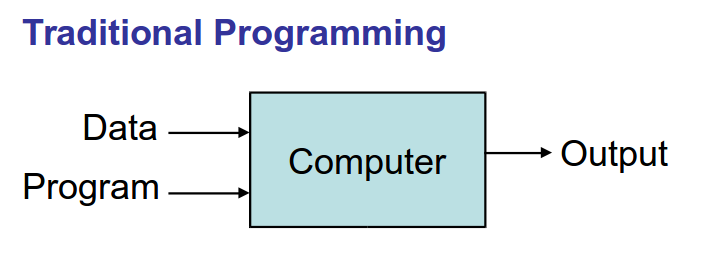

Machine learning (pembelajaran mesin) adalah sebuah ilmu yang mempelajari tentang bagaimana membuat mesin (komputer) dapat melakukan sesuatu tanpa diberikan perintah yang eksplisit. Menggunakan model statistik dan algoritma tertentu, komputer diberikan kemampuan untuk mengenali pola. Pola inilah yang digunakan sebagai modal untuk komputer dapat melakukan sesuatu.

Untuk dapat mengenali pola, maka komputer perlu diberikan pengalaman. Sama seperti manusia yang belajar melalui pengalaman dan mengambil pola dari kejadian tertentu. Pengalaman untuk komputer diberikan dalam bentuk data. Dalam kasus pengenalan suara, maka data yang diberikan adalah data suara. 

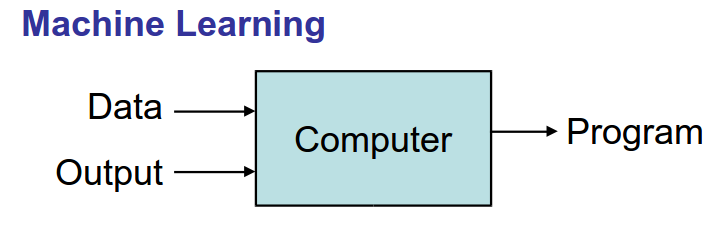

## Feature Engineering

Data spektrum bisa digunakan sebagai bahan inputan untuk pengenalan suara, bahkan seorang ahli bisa melihat suara dari spektrum yang digambarkannya. Untuk pengenalan suara oleh mesin, ukurannya bisa dianggap terlalu besar. Fitur yang terlalu banyak justru bisa mengurangi performa dari classifiernya baik karena overfitting atau karena waktu training yang lama. Hal ini disebut sebagai *Curse of Dimensionality* pada machine learning.

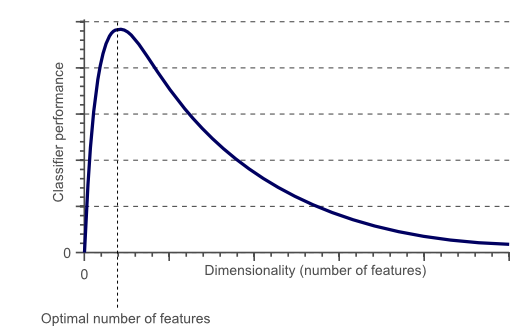

Kita perlu menentukan input yang representatif agar model yang kita buat bisa memiliki akurasi yang tinggi. Dari input tersebut, dipilih bagian yang menentukan klasifikasi model kita. Misalnya dalam pengenalan gambar kucing, hal yang paling menentukan seekor kucing adalah telinga, kumis, dan ekornya. Ini adalah fitur dari kucing. Tujuan kita adalah membuat mesin dapat mengenali bentuk telinga, bentuk kumis, dan bentuk ekor agar akurasi pengenal kucing kita meningkat. Hal inilah yang disebut sebagai feature engineering.

## Mel Frequency Cepstral Coefficient

Salah satu fitur yang digunakan dalam pengenalan audio adalah Mel Frequency Cepstral Coefficient (MFCC). Spektogram yang dihasilkan pada proses sebelumnya digunakan sebagai pita yang mewakili frekuensi distribusi. Setiap frekuensi dikelompokkan, baik secara linier maupun non linier. Sama seperti pada gambar equalizer berikut.

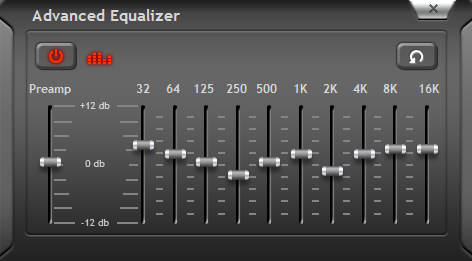

MFCC didapatkan melalui beberapa tahapan. FFT (untuk mendapatkan fitur seperti yang dibahas sebelumnya), Mel Scale Filtering (untuk mendapatkan Mel Spectrum), Transformasi Cosine (untuk mendapatkan koefisien Cepstral), dan penentuan fiturnya.

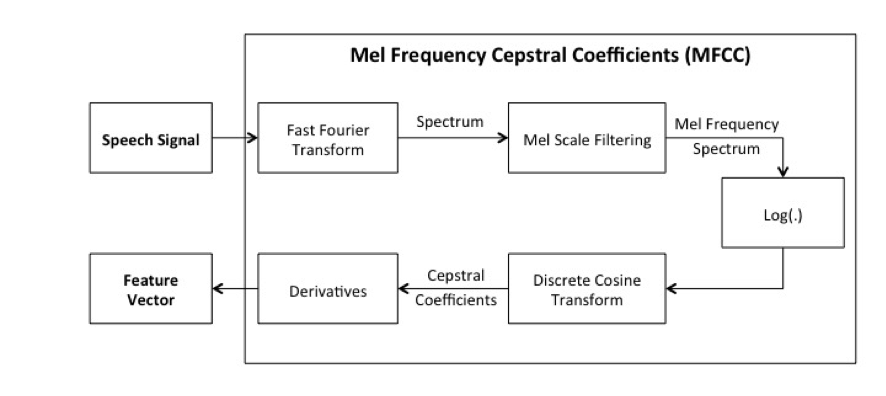

Mel Scale Filtering dimodelkan mengikuti cara kerja telinga manusia (cochlear) yang membedakan dengan ketat pada frekuensi rendah, dan longgar pada frekuensi tinggi.

Satuan frekuensi (f) yang digunakan pada FFT adalah Hz (getaran per detik). Satuan tersebut dapat diubah ke dalam skala Mel (m) dengan formula berikut :
$$m = 2595\ \log_{10}\left(1 + \frac{f}{700}\right)$$
$$f = 700\left(10^{\frac{m}{2595}}\ -\ 1\right)$$

Skala mel adalah skala perseptual dari pitch yang didengar. Perbandingannya dibuat dengan menyetarakan perseptual pitch sebesar 1000 mel sebagai nada sebesar 1000 Hz. Kata Mel diambil dari kata Melodi yang mengindikasikan bahwa skala ini berdasarkan perbandingan pitch. Skala ini diaplikasikan ke filter bank sebagai berikut

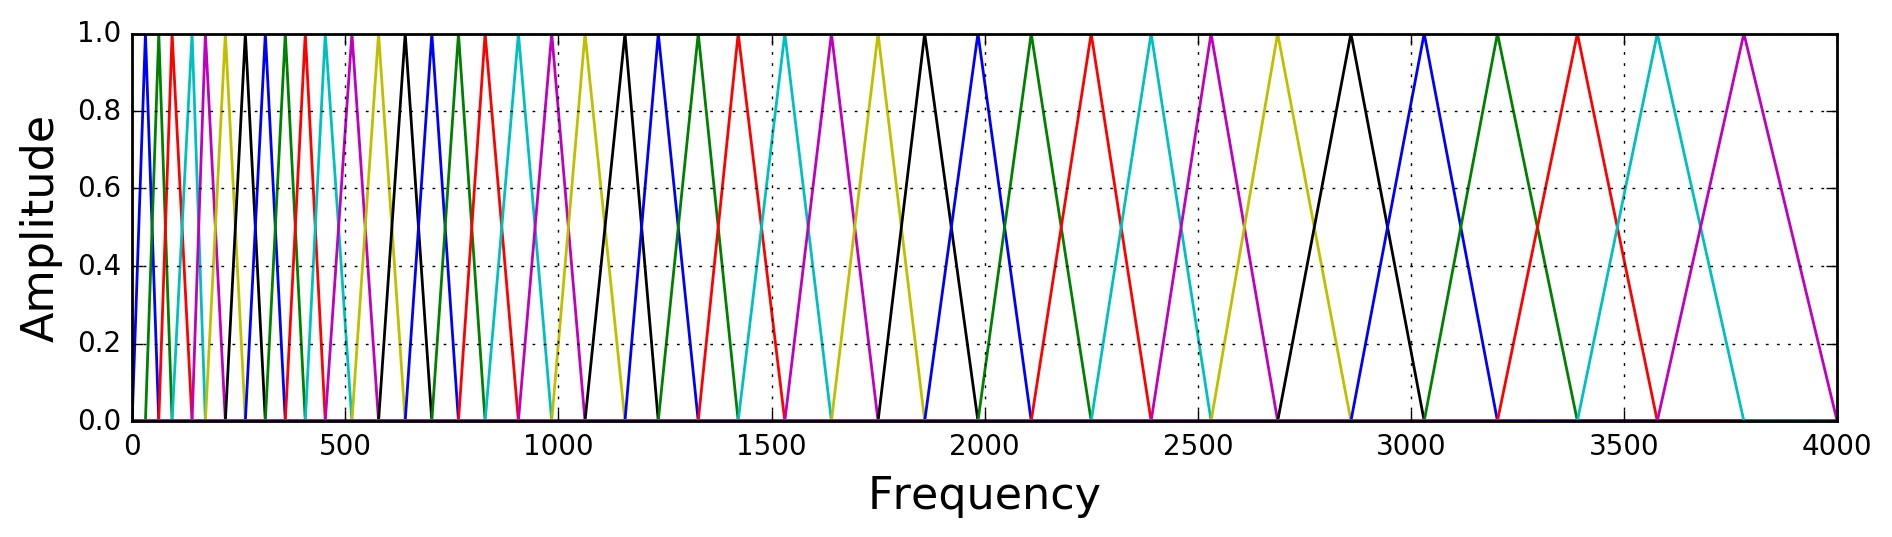

Setiap filter pada filter bank berbentuk segitiga dan bernilai 0 sampai 1. Pusatnya memiliki amplitudo 1 dan berkurang secara linier hingga 0 di ujung filter dan beririsan dengan filter sebelahnya. Lebar tiap filter diperbesar bertahap untuk menangkap frekuensi yang berbeda. Filter ini dapat dimodelkan secara matematis sebagai 

$$H_m(k) =
  \begin{cases}
      \hfill 0                                      \hfill & k < f(m - 1) \\
      \\
      \hfill \dfrac{k - f(m - 1)}{f(m) - f(m - 1)}  \hfill & f(m - 1) \leq k < f(m) \\
      \\
      \hfill 1                                      \hfill & k = f(m) \\
      \\
      \hfill \dfrac{f(m + 1) - k}{f(m + 1) - f(m)}  \hfill & f(m) < k \leq f(m + 1) \\
      \\
      \hfill 0                                      \hfill & k > f(m - 1) \\
  \end{cases}$$
  
Untuk mempelajari implementasinya lebih lanjut, bisa mengacu ke http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

## Training Model

Machine learning pada data suara dapat dimanfaatkan untuk berbagai hal :
- pengenalan suara (speech)
- pengenalan pembicara (speaker)
- pendeteksi penyakit
- dll

Tergantung dengan data apa yang kita masukkan sebagai input dan label apa yang kita berikan sebagai outputnya. 

In [ ]:
#install library yang dibutuhkan (kalo belum diinstall atau tidak terdeteksi)
!pip install pandas
!pip install sklearn
!pip install tensorflow

In [1]:
#import library
#note : scipy tidak bisa membaca file wav 24 bit. konversikan data suara ke 16 bit dulu

import numpy as np
import scipy.io.wavfile as wav
from scipy.fftpack import dct
from matplotlib import pyplot as plt
import sys
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
#credit from Tirtadwipa Manunggal (https://github.com/linerocks)
def STFT(x, N = 512, overlap = 0.5) :
    if overlap > 0.5 :
        overlap = 0.5
    elif overlap < 0.1 :
        overlap = 0.1
    
    # Calculating frames
    hop_size     = np.int( np.floor(N * (1 - overlap)) )
    total_frames = np.int( np.ceil(x.size / hop_size) )
    
    # Zero padding
    x = np.append( x, np.zeros((total_frames + 1) * hop_size - x.size) )
    
    # STFT container
    result = np.empty( (total_frames, np.int(N/2)), dtype=np.float32 )
    
    # Window
    H = 0.54 - 0.46 *  np.cos(np.arange(0, N) * 2 * np.pi / (N - 1))
        
    # Building
    for i in range(total_frames) :
        hop_index    = i * hop_size
        chunk        = x[hop_index : hop_index + N]
        frame        = np.multiply(chunk, H)
        spectrum     = np.abs(np.fft.fft(frame))
        result[i, :] = spectrum[0:np.int(N/2)]
    
    return result   

In [3]:
#Create Filterbank, credit https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
def filterbank(NFFT = 512, nfilt = 40, fs = 16000) :
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / fs)
    
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    return fbank.T

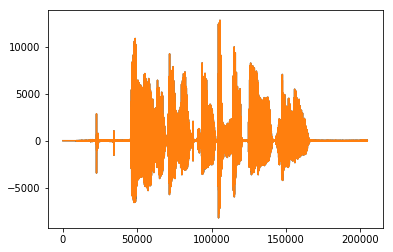

In [4]:
#buka file suara
#cek windows atau linux
if(sys.platform == 'linux' or 'darwin'):
    lokasi = 'data/contoh.wav'
elif(sys.platform == 'win32' or 'win64'):
    lokasi = 'data\\contoh.wav'

fs, y_wicara = wav.read(lokasi)

plt.plot(y_wicara)
plt.show()

#frame size
N = 512

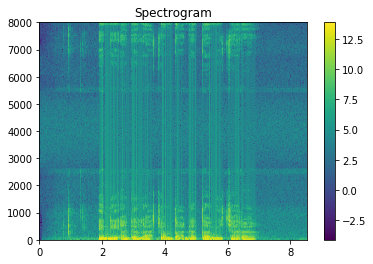

In [5]:
#Spectrum STFT langsung
spectrum = np.log(STFT(y_wicara,N))
plt.imshow(spectrum.T, origin='lower', aspect='auto', extent=[0, spectrum.size / fs, 0, 8000])
plt.title('Spectrogram')
plt.colorbar()

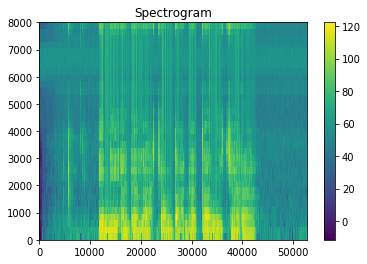

In [6]:
# Filterbank Spectrogram
spectrogram = np.dot(STFT(y_wicara), filterbank(N, nfilt=33, fs = fs))
spectrogram = 20 * np.log10(spectrogram)
plt.imshow(spectrogram.T, origin='lower', aspect='auto', extent=[0, spectrogram.size, 0, 8000])
plt.title('Spectrogram')
plt.colorbar()

## Discrete Cosine Transform

Langkah selanjutnya adalah menerapkan Transformasi Cosinus (Discrete Cosine Transform / DCT). Membuang $n$ buah koefisien dan liftering koefisien matriksnya. Lifter yang umum digunakan adalah 

$$l_i = 1 + \frac{D}{2}\sin\left(\frac{\pi i}{D}\right) $$

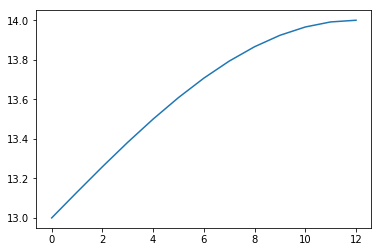

In [7]:
# Lifter untuk ncoeff = 13 dan D = 24
ncoeff = 13
D = 24
lifter = 1 + (D/2) + np.sin(np.pi * np.arange(ncoeff) / D)
plt.plot(lifter)

In [8]:
#Menghitung nilai MFCC
def mfcc(x, N = 512, ncoeff = 13, D = 24, fs = 16000):
    spectrogram = np.dot(STFT(x), filterbank(N, fs = fs))
    spectrogram = 20 * np.log10(spectrogram)
    mfcc = dct(spectrogram, type = 2, axis = 1, norm = 'ortho')[:, 1 : (ncoeff + 1)]
    lifter = 1 + (D/2) + np.sin(np.pi * np.arange(ncoeff) / D)
    mfcc = np.multiply(mfcc, lifter)
    return mfcc

(1600, 13)


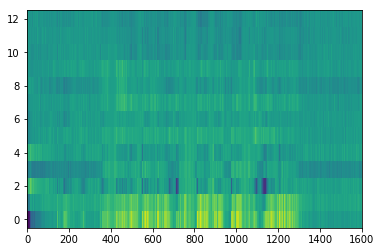

In [9]:
#Menerapkan MFCC ke data wicara
MFCC = mfcc(y_wicara)
print(MFCC.shape)
plt.imshow(MFCC.T, origin='lower', aspect='auto')

MFCC kadang dilengkapi dengan fungsi delta (perubahan nilai koefisien) dan fungsi double delta (perubahan dari nilai deltanya) agar fitur yang digambarkan lebih kuat.

Cara perhitungan fungsi delta ($\Delta$) dan double delta ($\Delta^{2}$) lebih lanjut dapat dilihat pada referensi berikut. ref : https://www.mathworks.com/help/audio/ref/mfcc.html

(1599, 13)


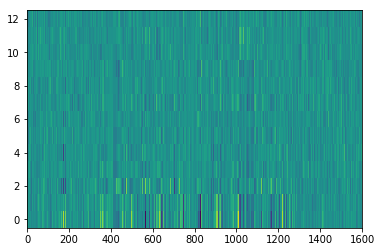

In [10]:
#Fungsi delta
delta = np.diff(MFCC, axis=0)
print(delta.shape)
plt.imshow(delta.T, origin='lower', aspect='auto')

(1598, 13)


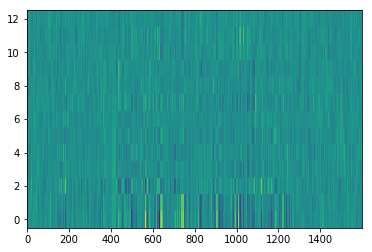

In [11]:
#Fungsi double delta
double_delta = np.diff(delta, axis=0)
print(double_delta.shape)
plt.imshow(double_delta.T, origin='lower', aspect='auto')

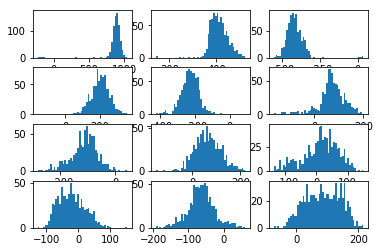

In [12]:
# Distribusi MFCC
fs, suara_mhsA = wav.read('data/Audio/a_60291.wav')
ncoeff = 12
mhsA_mfcc = mfcc(suara_mhsA, ncoeff=ncoeff)
for i in range(ncoeff):
    plt.subplot(4,3,i + 1)
    plt.hist(mhsA_mfcc[:,i], bins=50)

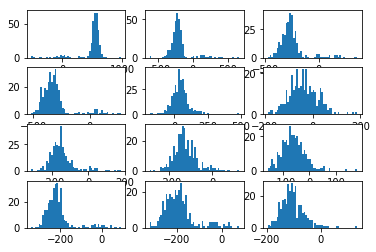

In [13]:
# Distribusi MFCC mahasiswa B
fs, suara_mhsB = wav.read('data/Audio/a_60191.wav')
ncoeff = 12
mhsB_mfcc = mfcc(suara_mhsB, ncoeff=ncoeff)
for i in range(ncoeff):
    plt.subplot(4,3,i + 1)
    plt.hist(mhsB_mfcc[:,i], bins=50)

## Data Preparation

In [14]:
# Data preparation
ncoeff = 13
with open('data/Audio/metadata.csv') as meta:
    reader = csv.reader(meta)
    next(reader, None)
    with open('data/data.csv', 'w') as data:
        data.write('file,mu0,mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8,mu9,mu10,mu11,mu12,id,speaker\n')
        for item in reader:
            data.write(item[0]+",")
            _, s = wav.read("data/Audio/" + item[0])
            feat = mfcc(s, ncoeff=ncoeff)
            for i in range(ncoeff):
                data.write("%.2f" %np.mean(feat[:,i]))
                data.write(",")
            data.write("%s,%s\n" %(item[2],item[4]))

**Gunakan library pandas untuk membuat dataframes**

In [15]:
features = pd.read_csv('data/data.csv')
features

,file,mu0,mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8,mu9,mu10,mu11,mu12,id,speaker
0,u_60441.wav,412.76,623.77,-108.93,397.01,-135.64,-64.99,-273.86,59.07,-121.03,-17.74,-107.69,2.72,-73.55,u,6044
1,7_60441.wav,93.59,433.51,109.13,163.16,80.13,190.22,0.20,111.31,49.34,19.32,-139.62,20.51,-128.86,7,6044
2,7_60362.wav,544.42,589.21,281.18,180.95,51.08,75.65,-69.14,66.00,-43.93,-14.39,-137.03,0.58,-104.53,7,6036
3,4_60181.wav,-26.46,398.94,-41.88,23.14,-18.29,140.72,-96.23,40.85,-98.89,50.45,-83.15,-16.93,-93.30,4,6018
4,o_60011.wav,325.45,369.81,354.97,184.84,78.21,30.53,0.22,-64.68,63.22,20.75,5.93,124.06,-88.18,o,6001
5,5_60741.wav,328.69,108.00,-201.04,255.38,-83.69,-10.05,-13.64,-80.90,3.47,-46.75,-45.52,-67.73,-74.05,5,6074
6,o_60411.wav,743.59,538.03,-13.56,204.21,-89.37,-35.11,-224.99,57.35,-50.12,-13.12,-132.88,-93.48,-173.55,o,6041
7,o_60741.wav,626.77,390.85,5.37,447.97,-246.91,-229.62,-104.95,-31.52,-15.88,-79.65,30.26,-62.46,-80.77,o,6074
8,u_60293.wav,433.27,516.63,4.51,364.64,-30.40,127.25,-23.67,-53.27,23.42,-18.81,-84.76,-13.05,-127.20,u,6029
9,9_60751.wav,28.43,237.11,-23.29,36.42,-107.75,9.89,-69.25,1.94,-29.31,-88.12,-54.06,-55.39,-28.33,9,6075


**Menormalkan data**

In [16]:
col = features.columns[1:-2]
features[col] = features[col].apply(lambda x : (x - x.min()) / (x.max() - x.min()))

**Melihat ada apa saja label di 'id'**

In [17]:
features['id'].unique()

array(['u', '7', '4', 'o', '5', '9', '1', '-', '8', 'e', 'a', '0', '6',
       'i', '2', '3'], dtype=object)

**Mentransformasikan label ke binary/numerik**

In [18]:
def transform_id(label) :
    if label == 'o' :
        return 0
    else :
        return 1

def transform_speaker(label) :
    if label == '6036' :
        return 0
    else :
        return 1

## Identifikasi Huruf "O"
**Apply the transformation function**

In [19]:
features['id'] = features['id'].apply(transform_id)

**Group input features**

In [20]:
input_features = features.drop(['file', 'id', 'speaker'], axis=1).values

**Group labels**

In [21]:
output_features = [ [i, -(i-1)] for i in features['id'].values]

**Split training and testing data**

In [22]:
X, X_test, Y, Y_test = train_test_split(input_features, output_features, test_size=0.3, random_state=42)

**Build our basic MLP**

In [23]:
# Parameters
learning_rate = 0.001
training_epochs = 1000
batch_size = 4
display_step = 50

# Network Parameters
n_hidden_1 = 10 # 1st layer number of features
n_hidden_2 = 10 # 2nd layer number of features
n_input = 13 # Number of feature
n_classes = 2 # Number of classes to predict

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



**Train the model**

In [24]:
# Launch the graph

sess = tf.Session()

sess.run(init)
# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(len(X)/batch_size)
    X_batches = np.array_split(X, total_batch)
    Y_batches = np.array_split(Y, total_batch)
    # Loop over all batches
    for i in range(total_batch):
        batch_x, batch_y = X_batches[i], Y_batches[i]
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                      y: batch_y})
        # Compute average loss
        avg_cost += c / total_batch
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
print("Optimization Finished!")

# Test model
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print("Accuracy:", accuracy.eval({x: X_test, y: Y_test},sess))
global result 
result = tf.argmax(pred, 1).eval({x: X_test, y: Y_test},sess)

Epoch: 0001 cost= 1.937083200
Epoch: 0051 cost= 0.119607048
Epoch: 0101 cost= 0.064863010
Epoch: 0151 cost= 0.032095550
Epoch: 0201 cost= 0.013853393
Epoch: 0251 cost= 0.004711378
Epoch: 0301 cost= 0.001355322
Epoch: 0351 cost= 0.000380454
Epoch: 0401 cost= 0.000103211
Epoch: 0451 cost= 0.000028418
Epoch: 0501 cost= 0.000008211
Epoch: 0551 cost= 0.000002365
Epoch: 0601 cost= 0.000000664
Epoch: 0651 cost= 0.000000187
Epoch: 0701 cost= 0.000000052
Epoch: 0751 cost= 0.000000016
Epoch: 0801 cost= 0.000000004
Epoch: 0851 cost= 0.000000000
Epoch: 0901 cost= 0.000000000
Epoch: 0951 cost= 0.000000000
Optimization Finished!
Accuracy: 0.9655172


In [25]:
#Close session
sess.close()